# 1D Token-Sequence Prediction

In [172]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random
import contextlib
from scipy.stats import skew, kurtosis
from scipy.spatial import distance
from statsmodels.tsa.stattools import acf, pacf
from collections import Counter
import matplotlib.pyplot as plt

#### Data Preparation

##### Geometric Brownian Motion Simulator

$S_t = S_0 \exp\left(\left(\mu - \frac{\sigma^2}{2}\right) t + \sigma W_t\right)$


$dS_t = \mu S_tdt + \sigma S_tdW_t \\$

$S_0$: Initial Stock price $\\$
$\mu$: Drift coefficient $\\$
$\sigma$: Volatility coefficient $\\$
$W_t$: Wiener Process (Brownian motion)

$W_t \sim \mathcal{N}(0, t)$

$dW_t \approx W_{t+\Delta t} - W_t \sim \mathcal{N}(0, \Delta t)$

$\ln(S_t) \sim \mathcal{N}\left( \ln(S_0) + \left(\mu - \frac{\sigma^2}{2}\right) t, \sigma^2 t \right)$

$S_t \sim \text{LogNormal}\left( \ln(S_0) + \left(\mu - \frac{\sigma^2}{2}\right) t, \sigma^2 t \right)$

$dS_t \sim \mathcal{N}(\mu S_t dt, \sigma^2 S_t^2 dt)$


In [2]:
def gbm_simulator(key, S0, mu, sigma, T, dt, n):
    # Time vector
    t = jnp.linspace(0, T, n)
    # Generate Wiener process increments
    W_increments = random.normal(key, (n,)) * jnp.sqrt(dt)
    # Cumulative sum to get the Wiener process
    W = jnp.cumsum(W_increments)   
    # Geometric Brownian Motion
    S = S0 * jnp.exp((mu - 0.5 * sigma**2) * t + sigma * W)   
    return t, S

In [3]:
S0 = 100.0      # Initial stock price
mu = 0.05       # Drift coefficient (e.g., 1% annual drift)
sigma = 0.2     # Volatility coefficient (e.g., 20% annual volatility)
T = 10.0        # Total time (5 year)
n = 100000      # Number of time steps
dt = T / n      # Time step size

key = random.PRNGKey(14)

# Simulate GBM
t, Price_GBM = gbm_simulator(key, S0, mu, sigma, T, dt, n)

# Price Deltas
Delta_GBM = jnp.diff(Price_GBM)

Data Illustration

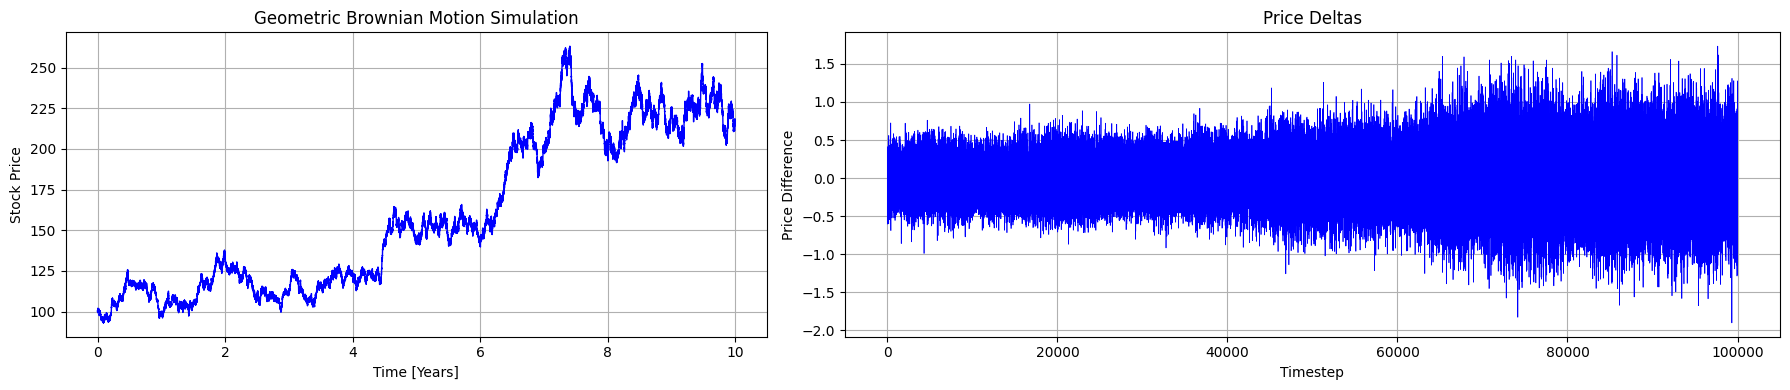

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(18, 4), gridspec_kw={'width_ratios': [1.5, 2]})
axs[0].plot(t, Price_GBM, color='blue', linewidth=1)
axs[0].set_title('Geometric Brownian Motion Simulation')
axs[0].set_xlabel('Time [Years]')
axs[0].set_ylabel('Stock Price')
axs[0].grid('True')

axs[1].plot(Delta_GBM, color='blue', linewidth=0.5)
axs[1].set_title('Price Deltas')
axs[1].set_xlabel('Timestep')
axs[1].set_ylabel('Price Difference')
axs[1].grid('True')
plt.tight_layout()
plt.show()

BINWIDTH

In [5]:
bin_width = 0.05

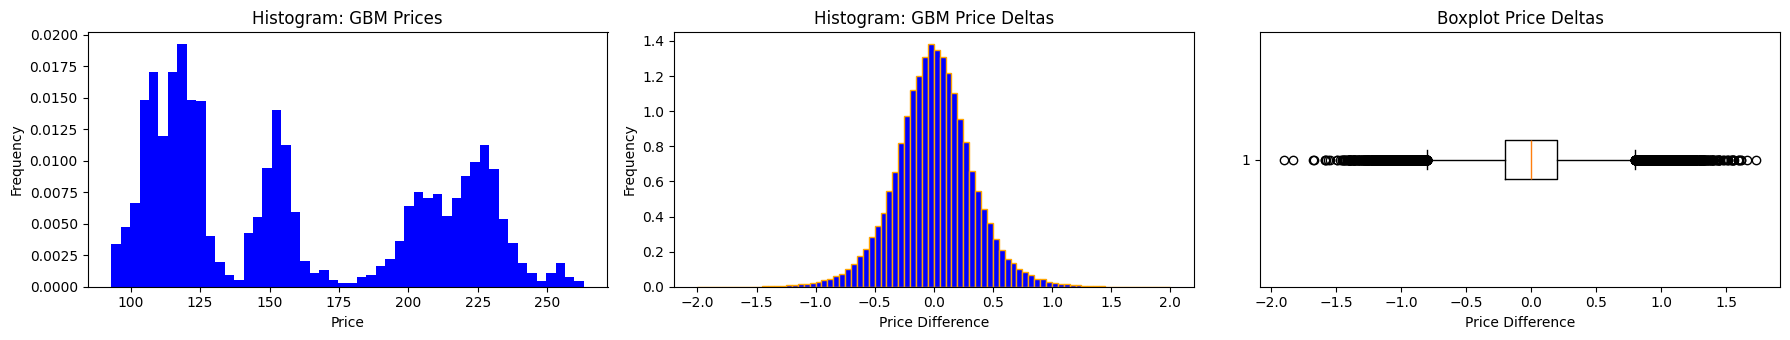

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

# Histogram: GBM Prices
axs[0].hist(Price_GBM, bins=50, color='blue', density=True)
axs[0].set_title('Histogram: GBM Prices')
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Frequency')

bins = np.arange(-2, 2 + bin_width, bin_width)

# Histogram: GBM Price Deltas
axs[1].hist(Delta_GBM, bins=bins, edgecolor='orange', color='blue', density=True)
axs[1].set_title('Histogram: GBM Price Deltas')
axs[1].set_xlabel('Price Difference')
axs[1].set_ylabel('Frequency')

# Boxplot Price Deltas
axs[2].boxplot(Delta_GBM, vert=False)
axs[2].set_title('Boxplot Price Deltas')
axs[2].set_xlabel('Price Difference')
plt.tight_layout()
plt.show()


Discretizing Data and Train-Val-Test Split

In [7]:
data = np.array(Delta_GBM)

# Bin range and Bin width
bin_start = -2
bin_stop = 2

num_bins = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins
bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

# Tokenize the data
tokenized_data = np.digitize(data, bins=bin_edges, right=False) - 1

# Clip any deltas below -0.7 to the first bin and above 0.7 to the last bin
tokenized_data = np.clip(tokenized_data, 0, num_bins - 1)

# Train / Test Split
train_data_temp, temp_data = train_test_split(tokenized_data, train_size=0.6, shuffle=False)
val_data_temp, test_data_temp = train_test_split(temp_data, test_size=0.5, shuffle=False)

def prep_data(seq_len, start_indexes, data):
    final_list = []
    for i in start_indexes:
        final_list.append(data[i:i+seq_len])
    return final_list

print('Number of Tokens:', num_bins)

Number of Tokens: 80


LSTM Model

In [8]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden=None):
        # A sequence of 50 tokens is passed to the embedding layer and we get the embeddings for each token (dimension: 32)
        embedded = self.embedding(x)                            # Shape: [batch_size, sequence_length, embedding_dim] [1, 50, 32]
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(embedded, hidden)      # Input: 50 tokens, Output: 50 hidden states with dimension 128
        # Apply fully connected layer to each time step
        logits = self.fc(lstm_out)                              # Shape: [batch_size, sequence_length, output_dim]
        
        return logits, hidden                                   # Return predictions for each time step

#### Train setting:

| Train set:                           |     $\approx$ 60'000         |
| ------------------------------------ | ---------------------------- |
| **Sequence Length:**                 | **50**                       |
| Sequences for a full epoch:          | $\approx$ 1200               |
| **Batch size:**                      | **512**                      |
| Episode length:                      | 1 Batch or 512 sequences     |


PARAMETERS

In [9]:
seq_len = 50                                                    # Sequence Length
batch_size = 512                                                # Batch Size
learning_rate = 0.001                                           # Learning Rate Adam Optimizer
num_episodes = int(len(train_data_temp)/(seq_len*batch_size))   # Number of episodes for one Epoch

num_epochs = 1000

VALIDATION & TEST DATA

In [10]:
n_val_seq = len(val_data_temp) // seq_len
val_data = [val_data_temp[i*seq_len:(i+1)*seq_len] for i in range(n_val_seq)]

n_test_seq = len(test_data_temp) // seq_len
test_data = [test_data_temp[i*seq_len:(i+1)*seq_len] for i in range(n_test_seq)]

TRAINING

In [11]:
ss_model = LSTMModel(vocab_size=num_bins, embedding_dim=32, hidden_dim=64, output_dim=num_bins)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ss_model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

best_val_loss = float('inf')

for epoch in range(num_epochs):

    avg_train_loss = 0
    avg_val_loss = 0

    for episode in range(num_episodes):

        ## ============
        ## TRAINING
        ## ============

        ss_model.train()
        ss_model.zero_grad()

        # Sample the Batch 
        start_train_idx = np.random.choice(range(len(train_data_temp) - seq_len), size=batch_size, replace=True)
        train_data = prep_data(seq_len=seq_len, start_indexes=start_train_idx, data=train_data_temp)

        # Create Tensor of Sequence and Target

        sequence_inputs = torch.tensor(np.array([seq[:-1] for seq in train_data]))    # Remove Last Token
        targets = torch.tensor(np.array([seq[1:] for seq in train_data]))             # Remove First Token

        # Forward pass: Shape [batch_size, sequence_length - 1, output_dim]
        logits, _ = ss_model(sequence_inputs)

        # [batch_size*sequence_length-1, output_dim/unique Tokens]
        logits = logits.view(-1, logits.size(-1))
        # Flatten targets: [batch_size*sequence_length-1]
        targets = targets.view(-1)

        loss = criterion(logits, targets)          # Loss
        loss.backward()                            # Backward pass
        optimizer.step()                           # Update weights
        avg_train_loss += loss.item()              # Save Loss

        ## ============
        ## VALIDATION
        ## ============
        
        ss_model.eval()
        
        sequence_inputs = torch.tensor([seq[:-1] for seq in val_data])  # Remove Last Token
        targets = torch.tensor([seq[1:] for seq in val_data])
        
        with torch.no_grad():
            logits, _ = ss_model(sequence_inputs)       # Forward Pass
            logits = logits.view(-1, logits.size(-1))   # Flatten Logits
            targets = targets.view(-1)                  # Flatten targets
            loss = criterion(logits, targets)           # Loss
            avg_val_loss += loss.item()                 # Save Loss

    epoch_train_loss = avg_train_loss/num_episodes      # Avg Train Loss after Epoch
    epoch_val_loss = avg_val_loss/num_episodes          # Avg Val Loss after Epoch
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)

    if epoch_val_loss < best_val_loss:
        best_val_loss = best_val_loss
        torch.save(ss_model.state_dict(), 'ss_model_weights.pth')
    
    print(f"Epoch {epoch} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")


/var/folders/1x/hjv8bl714_xgsbdy8fp5kj140000gn/T/ipykernel_81664/2833100427.py:54: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  sequence_inputs = torch.tensor([seq[:-1] for seq in val_data])  # Remove Last Token


Epoch 0 - Train Loss: 4.3942 - Val Loss: 4.3791
Epoch 1 - Train Loss: 4.3743 - Val Loss: 4.3664
Epoch 2 - Train Loss: 4.3519 - Val Loss: 4.3530
Epoch 3 - Train Loss: 4.3286 - Val Loss: 4.3382
Epoch 4 - Train Loss: 4.3017 - Val Loss: 4.3208
Epoch 5 - Train Loss: 4.2696 - Val Loss: 4.2999
Epoch 6 - Train Loss: 4.2293 - Val Loss: 4.2738
Epoch 7 - Train Loss: 4.1759 - Val Loss: 4.2407
Epoch 8 - Train Loss: 4.1072 - Val Loss: 4.1978
Epoch 9 - Train Loss: 4.0188 - Val Loss: 4.1416
Epoch 10 - Train Loss: 3.9043 - Val Loss: 4.0685
Epoch 11 - Train Loss: 3.7661 - Val Loss: 3.9805
Epoch 12 - Train Loss: 3.6137 - Val Loss: 3.8953
Epoch 13 - Train Loss: 3.4886 - Val Loss: 3.8383
Epoch 14 - Train Loss: 3.3831 - Val Loss: 3.8146
Epoch 15 - Train Loss: 3.3061 - Val Loss: 3.8122
Epoch 16 - Train Loss: 3.2506 - Val Loss: 3.8192
Epoch 17 - Train Loss: 3.2023 - Val Loss: 3.8290
Epoch 18 - Train Loss: 3.1628 - Val Loss: 3.8394
Epoch 19 - Train Loss: 3.1479 - Val Loss: 3.8495
Epoch 20 - Train Loss: 3.1174 

Loss and Entropy

In [12]:
def calculate_entropy(sequence):
    token_counts = Counter(sequence)
    total_tokens = len(sequence)
    # Probability distribution of tokens
    probabilities = {token: count / total_tokens for token, count in token_counts.items()}
    # Calculate the Shannon entropy
    entropy = -sum(p * np.log(p) for p in probabilities.values())
    return entropy

In [14]:
print('Entropy of Validation Data:', round(calculate_entropy(val_data_temp), 4))

Entropy of Validation Data: 3.5243


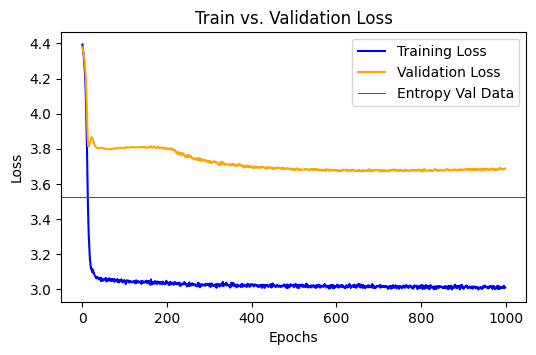

In [15]:
plt.figure(figsize=(6, 3.5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label = 'Validation Loss', color='orange')
plt.axhline(calculate_entropy(val_data_temp), color='red', linewidth=0.7, label='Entropy Val Data')
plt.title('Train vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [245]:
# ## NUMBER OF BINS: 6
# train_loss_02 = train_losses
# val_loss_02 = val_losses
# ## NUMBER OF BINS 13
# train_loss_01 = train_losses
# val_loss_01 = val_losses
# ## NUMBER OF BINS 27
# train_loss_005 = train_losses
# val_loss_005 = val_losses

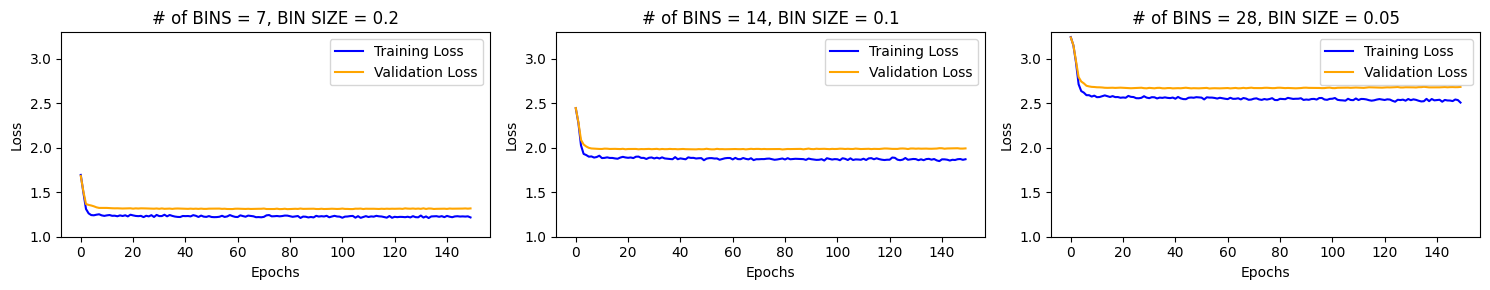

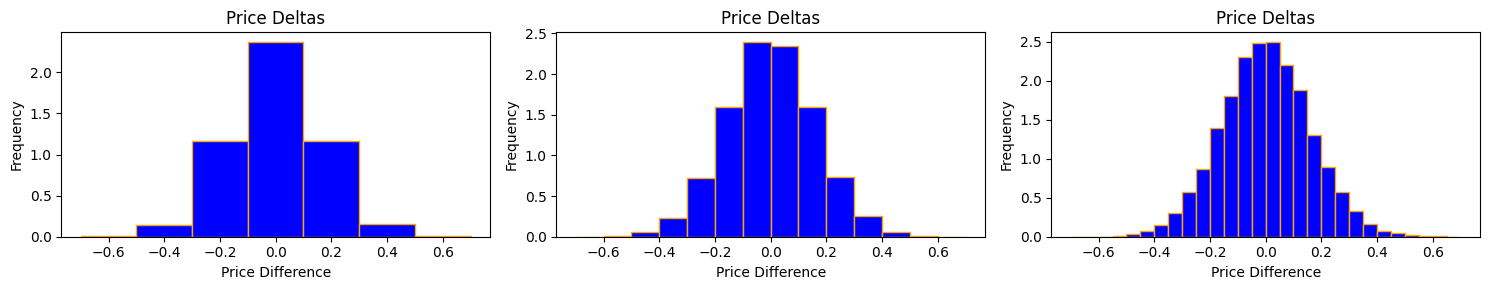

In [277]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (15,3))

axs[0].plot(train_loss_02, label='Training Loss', color='blue')
axs[0].plot(val_loss_02, label = 'Validation Loss', color='orange')
axs[0].set_title('# of BINS = 7, BIN SIZE = 0.2')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim(1,3.3)
axs[0].legend()

axs[1].plot(train_loss_01, label='Training Loss', color='blue')
axs[1].plot(val_loss_01, label = 'Validation Loss', color='orange')
axs[1].set_title('# of BINS = 14, BIN SIZE = 0.1')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_ylim(1,3.3)
axs[1].legend()

axs[2].plot(train_loss_005, label='Training Loss', color='blue')
axs[2].plot(val_loss_005, label = 'Validation Loss', color='orange')
axs[2].set_title('# of BINS = 28, BIN SIZE = 0.05')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Loss')
axs[2].set_ylim(1,3.3)
axs[2].legend()

plt.tight_layout()
plt.show()

bins_005 = np.arange(-0.7, 0.7 + 0.05, 0.05)
bins_01 = np.arange(-0.7, 0.7 + 0.1, 0.1)
bins_02 = np.arange(-0.7, 0.7 + 0.2, 0.2)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (15,3))

# Histogram: GBM Price Deltas
axs[0].hist(Delta_GBM, bins=bins_02, edgecolor='orange', color='blue', density=True)
axs[0].set_title('Price Deltas')
axs[0].set_xlabel('Price Difference')
axs[0].set_ylabel('Frequency')

axs[1].hist(Delta_GBM, bins=bins_01, edgecolor='orange', color='blue', density=True)
axs[1].set_title('Price Deltas')
axs[1].set_xlabel('Price Difference')
axs[1].set_ylabel('Frequency')

axs[2].hist(Delta_GBM, bins=bins_005, edgecolor='orange', color='blue', density=True)
axs[2].set_title('Price Deltas')
axs[2].set_xlabel('Price Difference')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#### EVALUATION AND TESTING with Teacher forcing

In [16]:
evaluation_model = LSTMModel(vocab_size=num_bins, embedding_dim=32, hidden_dim=64, output_dim=num_bins)
evaluation_model.load_state_dict(torch.load('ss_model_weights.pth', weights_only=False))

val_loss = []
val_perplexity = []

test_loss = []
test_perplexity = []

evaluation_model.eval()
with torch.no_grad():
    
    # Validation Data
    for sequence in val_data:
        
        sequence_input = torch.tensor(sequence[:-1]).unsqueeze(0)   # Exclude last token
        targets = torch.tensor(sequence[1:]).unsqueeze(0)           # Exclude first token
        logits, _ = evaluation_model(sequence_input)                # Forward pass
        logits = logits.view(-1, logits.size(-1))                   # Shape: [49, 27]
        targets = targets.view(-1)                                  # Shape: [49]
        
        # Cross entropy Loss
        loss = criterion(logits, targets)
        val_loss.append(loss.item())

        # Log probabilities
        log_probs = F.log_softmax(logits, dim=-1)
        target_log_probs = log_probs[range(len(targets)), targets]

        # Perplexity: exp(-average log probability)
        avg_log_prob = target_log_probs.mean()
        perplexity = torch.exp(-avg_log_prob).item()
        val_perplexity.append(perplexity)
    
    for sequence in test_data:

        sequence_input = torch.tensor(sequence[:-1]).unsqueeze(0)   # Exclude last token
        targets = torch.tensor(sequence[1:]).unsqueeze(0)           # Exclude first token
        logits, _ = evaluation_model(sequence_input)                # Forward pass
        logits = logits.view(-1, logits.size(-1))                   # Shape: [49, 27]
        targets = targets.view(-1)                                  # Shape: [49] 
        
        # Cross entropy Loss
        loss = criterion(logits, targets)
        test_loss.append(loss.item())

        # Log probabilities
        log_probs = F.log_softmax(logits, dim=-1)
        target_log_probs = log_probs[range(len(targets)), targets]

        # Perplexity: exp(-average log probability)
        avg_log_prob = target_log_probs.mean()
        perplexity = torch.exp(-avg_log_prob).item()
        test_perplexity.append(perplexity)

Perplexity Score


$\text{PP}_N(x) = \exp\left(-\frac{1}{N} \sum_{i=1}^{N} \log P(x_i \mid x_{1:i-1})\right)$

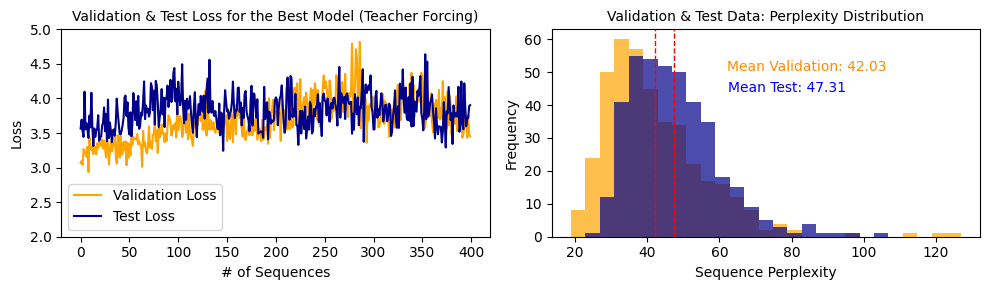

In [24]:
val_perplexity = np.array(val_perplexity)
test_perplexity = np.array(test_perplexity)

mean_test = np.mean(test_perplexity)
mean_val = np.mean(val_perplexity)

bin_start = min(np.min(val_perplexity), np.min(test_perplexity))
bin_stop = max(np.max(val_perplexity), np.max(test_perplexity))
bin_width = 4
bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# Plot 1: Validation & Test Loss
axs[0].plot(val_loss, label='Validation Loss', color='orange')
axs[0].plot(test_loss, label='Test Loss', color='darkblue')
axs[0].legend()
axs[0].set_title('Validation & Test Loss for the Best Model (Teacher Forcing)', size=10)
axs[0].set_xlabel('# of Sequences')
axs[0].set_ylabel('Loss')
axs[0].set_ylim(2,5)

# Plot 2: Histogram of Perplexity Distribution
axs[1].hist(val_perplexity, color='orange', bins=bin_edges, alpha=0.7, label='Validation Perplexity')
axs[1].hist(test_perplexity, color='darkblue', bins=bin_edges, alpha=0.7, label='Test Perplexity')
axs[1].set_title('Validation & Test Data: Perplexity Distribution', size=10)
axs[1].set_xlabel('Sequence Perplexity')
axs[1].set_ylabel('Frequency')
#axs[1].set_xlim(1,15)

#Vertical lines for the mean values on the histogram
axs[1].axvline(mean_val, color='red', linewidth=1, linestyle='dashed')
axs[1].axvline(mean_test, color='red', linewidth=1, linestyle='dashed')
axs[1].text(mean_val+20.0, axs[1].get_ylim()[1] * 0.8, f'Mean Validation: {mean_val:.2f}', color='darkorange')
axs[1].text(mean_test+15.0, axs[1].get_ylim()[1] * 0.7, f'Mean Test: {mean_test:.2f}', color='blue')

plt.tight_layout()
plt.show()


#### Inference on Test Data

In [45]:
test_losses = []
trajectories = []

evaluation_model.eval()
with torch.no_grad():

    for sequence in test_data:
    
        token_loss = 0

        # First real Token as start
        init_real_token = sequence[0]
        sim_trajectory = [init_real_token]

        # Initialize hidden and cell states to zero
        ## PLEASE ADJUST WHEN HAVING MULTIPLE LSTM LAYERS
        h_n = torch.zeros(1, 1, 64)
        c_n = torch.zeros(1, 1, 64)
        ##

        for i in range(1, len(sequence)):
            
            # Last value in Trajectory
            sequence_input = torch.tensor([sim_trajectory[-1]]).unsqueeze(0)

            # Model prediction and hidden/cell states
            logits, (h_n, c_n) = evaluation_model(sequence_input, (h_n, c_n))

            # Softmax
            probs = torch.softmax(logits, dim=-1)
            probs = probs.squeeze()
            # Sample next Token
            predicted_token = torch.multinomial(probs, num_samples=1).item()
            # Add to trajectory
            sim_trajectory.append(predicted_token)

            # Loss
            true_token = torch.tensor([sequence[i]]).unsqueeze(0)
            true_token = true_token.view(-1)
            logits = logits.view(-1, logits.size(-1))
            loss = criterion(logits, true_token)
            token_loss += loss.item()
        
        test_losses.append(token_loss/len(sequence))
        trajectories.append(sim_trajectory)

Entropy of the Distribution (Test data)

Shannon Entropy  $H(\text{x}) = - \sum_{i} p(\text{x}_i) \log p(\text{x}_i)$

Shannon Entropy in bits  $H(\text{x}) = - \sum_{i} p(\text{x}_i) \bf{\log_2 p(\text{x}_i)}$


In [294]:
def calculate_entropy_bits(sequence):
    token_counts = Counter(sequence)
    total_tokens = len(sequence)
    # Probability distribution of tokens
    probabilities = {token: count / total_tokens for token, count in token_counts.items()}
    # Calculate the Shannon entropy
    entropy = -sum(p * np.log2(p) for p in probabilities.values())
    return entropy

In [88]:
pure_fake = [trajectories[i][1:] for i in range(len(trajectories))]
flatten_fake = [token for seq in pure_fake for token in seq]

real_entropy = round(calculate_entropy(test_data_temp), 4)
fake_entropy = round(calculate_entropy(flatten_fake), 4)

real_seq_entropy = []
fake_seq_entropy = []

for i in range(len(test_data)):
    real_seq_entropy.append(calculate_entropy(test_data[i]))
    fake_seq_entropy.append(calculate_entropy(pure_fake[i]))

mean_real = np.mean(real_seq_entropy)
mean_fake = np.mean(fake_seq_entropy)

bin_start = min(np.min(real_seq_entropy), np.min(fake_seq_entropy))
bin_stop = max(np.max(real_seq_entropy), np.max(fake_seq_entropy))
bin_width = 0.05
bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)


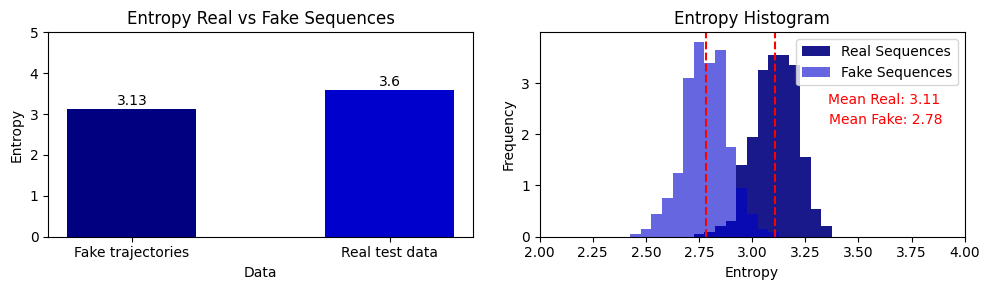

In [165]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

# Plot Barplot
bars = axs[0].bar(x = ['Fake trajectories', 'Real test data'], height=[fake_entropy, real_entropy], width=0.5, color=['navy', 'mediumblue'])
for bar in bars:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')
axs[0].set_title('Entropy Real vs Fake Sequences')
axs[0].set_xlabel('Data')
axs[0].set_ylabel('Entropy')
axs[0].set_ylim(0, 5)

# Plot histograms
axs[1].hist(real_seq_entropy, bins=bin_edges, color='navy', alpha=0.9, label='Real Sequences', density=True)
axs[1].hist(fake_seq_entropy, bins=bin_edges, color='mediumblue', alpha=0.6, label='Fake Sequences', density=True)

# Plot vertical lines for means
axs[1].axvline(mean_real, color='red', linewidth=1.5, linestyle='dashed')
axs[1].axvline(mean_fake, color='red', linewidth=1.5, linestyle='dashed')
y_limit = axs[1].get_ylim()[1]
axs[1].text(mean_real + 0.25, y_limit * 0.65, f'Mean Real: {mean_real:.2f}', color='red')
axs[1].text(mean_fake + 0.58, y_limit * 0.55, f'Mean Fake: {mean_fake:.2f}', color='red')

# Set titles and labels
axs[1].set_title('Entropy Histogram')
axs[1].set_xlabel('Entropy')
axs[1].set_ylabel('Frequency')
axs[1].set_xlim(2,4)
axs[1].legend()

plt.tight_layout()
plt.show()

#print(f"\033[0mREAL DATA Token level entropy:\033[1m {real_entropy}")
#print(f"\033[0mFAKE DATA Token level entropy:\033[1m {fake_entropy}")


In [173]:
def kl_divergence(real_sequence, fake_sequence):

    # Frequency of each token in the real and fake sequences
    real_counts = Counter(real_sequence)
    fake_counts = Counter(fake_sequence)
    
    # Total number of tokens in each sequence
    total_real_tokens = len(real_sequence)
    total_fake_tokens = len(fake_sequence)
    
    # Probability distribution of tokens
    real_probabilities = {token: count / total_real_tokens for token, count in real_counts.items()}
    fake_probabilities = {token: count / total_fake_tokens for token, count in fake_counts.items()}
    
    # KL divergence
    kl_divergence = 0
    for token, p_real in real_probabilities.items():
        p_fake = fake_probabilities.get(token, 1e-10)  # Small value to avoid division by zero
        kl_divergence += p_real * np.log2(p_real / p_fake)
    
    return kl_divergence

def kl_jl(p_real, p_fake):

    kl_divergence = 0
    for token, p_r in p_real.items():
        p_f = p_fake.get(token, 1e-10)  # Add a small value to avoid division by zero
        kl_divergence += p_r * np.log2(p_r / p_f)
    return kl_divergence

def calculate_js_divergence(real_sequence, fake_sequence):

    # Frequency of each token in the real and fake sequences
    real_counts = Counter(real_sequence)
    fake_counts = Counter(fake_sequence)
    
    # Total number of tokens in each sequence
    total_real_tokens = len(real_sequence)
    total_fake_tokens = len(fake_sequence)
    
    # Probability distribution of tokens
    real_probabilities = {token: count / total_real_tokens for token, count in real_counts.items()}
    fake_probabilities = {token: count / total_fake_tokens for token, count in fake_counts.items()}
    
    # Average distribution M
    all_tokens = set(real_probabilities.keys()).union(set(fake_probabilities.keys()))
    average_probabilities = {token: 0.5 * (real_probabilities.get(token, 0) + fake_probabilities.get(token, 0)) for token in all_tokens}
    
    # KL divergence between real and average, and fake and average
    kl_real_to_avg = kl_jl(real_probabilities, average_probabilities)
    kl_fake_to_avg = kl_jl(fake_probabilities, average_probabilities)
    
    # Calculate JS divergence
    js_divergence = 0.5 * (kl_real_to_avg + kl_fake_to_avg)
    
    return js_divergence

KL Divergence

$D_{KL}(P_{\text{real}} \parallel P_{\text{fake}}) = \sum_{i} p_{\text{real}}(x_i) \log \left( \frac{p_{\text{real}}(x_i)}{p_{\text{fake}}(x_i)} \right)$

Jensen-Shannon Divergence


$D_{JS}(P_{\text{real}} \parallel P_{\text{fake}}) = \frac{1}{2} D_{KL}(P_{\text{real}} \parallel M) + \frac{1}{2} D_{KL}(P_{\text{fake}} \parallel M)$, 

$\text{where } M = \frac{1}{2} (P_{\text{real}} + P_{\text{fake}})$


In [175]:
kl_div = round(kl_divergence(train_data_temp, flatten_fake),4)
js_div = round(calculate_js_divergence(test_data_temp, flatten_fake),4)

print("KL Divergence between Real and Fake Sequences (in bits):", kl_div)
print('')
print("JS Divergence between Real and Fake Sequences (in bits):", js_div)


KL Divergence between Real and Fake Sequences (in bits): 0.0153

JS Divergence between Real and Fake Sequences (in bits): 0.0716


#### Summary Statistics

In [161]:
def calculate_statistics(trajectories):
    means = []
    variances = []
    std_devs = []
    skewness = []
    kurtos = []
    max_vals = []
    min_vals = []

    for traj in trajectories:
        means.append(np.mean(traj))
        variances.append(np.var(traj))
        std_devs.append(np.std(traj))
        skewness.append(skew(traj))
        kurtos.append(kurtosis(traj))
        max_vals.append(np.max(traj))
        min_vals.append(np.min(traj))
    
    return means, variances, std_devs, skewness, kurtos, max_vals, min_vals

# Statistics for real and simulated trajectories
real_means, real_variances, real_std_devs, real_skew, real_kurtosis, real_max_vals, real_min_vals = calculate_statistics(test_data)
sim_means, sim_variances, sim_std_devs, sim_skew, sim_kurtosis, sim_max_vals, sim_min_vals = calculate_statistics(pure_fake)

bin_start_mean = min(np.min(sim_means), np.min(real_means))
bin_stop_mean = max(np.max(sim_means), np.max(real_means))
bin_width_mean = 0.2
bin_edges_mean = np.arange(bin_start_mean, bin_stop_mean + bin_width_mean, bin_width_mean)

bin_start_var = min(np.min(sim_variances), np.min(real_variances))
bin_stop_var = max(np.max(sim_variances), np.max(real_variances))
bin_width_var = 5
bin_edges_var = np.arange(bin_start_var, bin_stop_var + bin_width_var, bin_width_var)

bin_start_skew = min(np.min(sim_skew), np.min(real_skew))
bin_stop_skew = max(np.max(sim_skew), np.max(real_skew))
bin_width_skew = 0.2
bin_edges_skew = np.arange(bin_start_skew, bin_stop_skew + bin_width_skew, bin_width_skew)

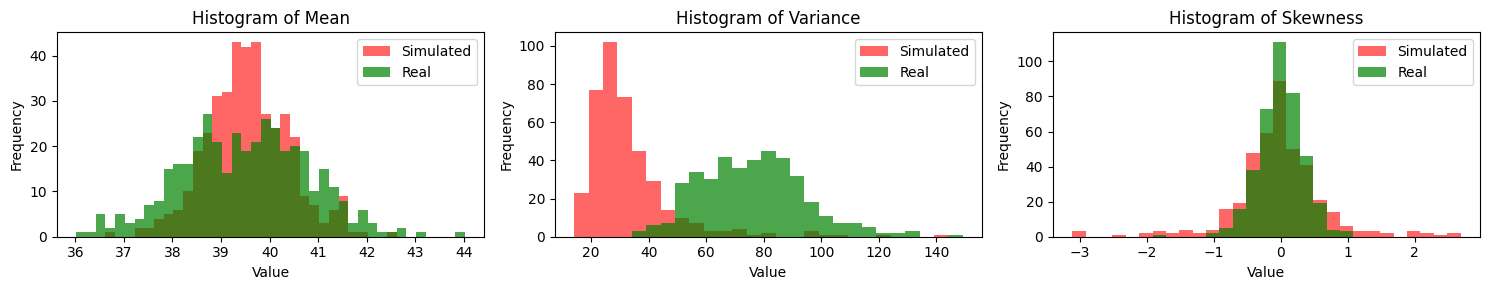

In [162]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3))

# Plot 1: Mean Distribution
axs[0].hist(sim_means, bins=bin_edges_mean, alpha=0.6, label='Simulated', color='red')
axs[0].hist(real_means, bins=bin_edges_mean, alpha=0.7, label='Real', color='green')
axs[0].legend(loc='upper right')
axs[0].set_title('Histogram of Mean')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')

# Plot 1: Variance Distribution
axs[1].hist(sim_variances, bins=bin_edges_var, alpha=0.6, label='Simulated', color='red')
axs[1].hist(real_variances, bins=bin_edges_var, alpha=0.7, label='Real', color='green')
axs[1].legend(loc='upper right')
axs[1].set_title('Histogram of Variance')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')

# Plot 2: Skewness Distribution
axs[2].hist(sim_skew, bins=bin_edges_skew, alpha=0.6, label='Simulated', color='red')
axs[2].hist(real_skew, bins=bin_edges_skew, alpha=0.7, label='Real', color='green')
axs[2].legend(loc='upper right')
axs[2].set_title('Histogram of Skewness')
axs[2].set_xlabel('Value')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Trajectories

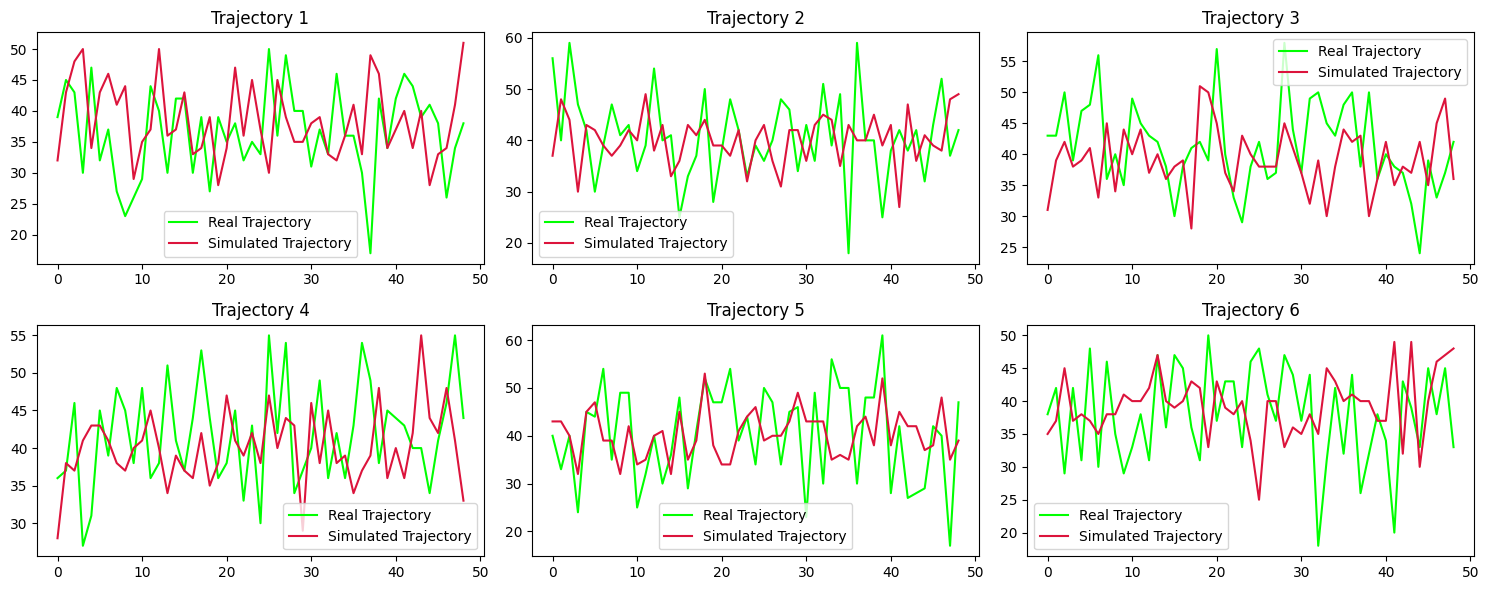

In [113]:
fig, axes = plt.subplots(2, 3, figsize=(15, 6))  # 2 rows, 3 columns, and adjust the size
axes = axes.flatten()
for i in range(6):
    axes[i].plot(test_data[i][1:], label='Real Trajectory', color = 'lime')
    axes[i].plot(pure_fake[i], label='Simulated Trajectory', color = 'crimson')
    axes[i].legend()
    axes[i].set_title(f'Trajectory {i+1}')
plt.tight_layout()
plt.show()

Inference with ARGMAX instead of SAMPLING next TOKEN

In [114]:
test_losses_2 = []
trajectories_2 = []

evaluation_model.eval()
with torch.no_grad():

    for sequence in test_data:
    
        token_loss = 0

        # First real Token as start
        init_real_token = sequence[0]
        sim_trajectory = [init_real_token]

        # Initialize hidden and cell states to zero
        ## PLEASE ADJUST WHEN HAVING MULTIPLE LSTM LAYERS
        h_n = torch.zeros(1, 1, 64)
        c_n = torch.zeros(1, 1, 64)
        ##

        for i in range(1, len(sequence)):
            
            # Last value in Trajectory
            sequence_input = torch.tensor([sim_trajectory[-1]]).unsqueeze(0)

            # Model prediction and hidden/cell states
            logits, (h_n, c_n) = evaluation_model(sequence_input, (h_n, c_n))

            # Softmax
            probs = torch.softmax(logits, dim=-1)
            probs = probs.squeeze()
            # Sample next Token
            predicted_token = torch.argmax(probs).item()
            # Add to trajectory
            sim_trajectory.append(predicted_token)

            # Loss
            true_token = torch.tensor([sequence[i]]).unsqueeze(0)
            true_token = true_token.view(-1)
            logits = logits.view(-1, logits.size(-1))
            loss = criterion(logits, true_token)
            token_loss += loss.item()
        
        test_losses_2.append(token_loss/len(sequence))
        trajectories_2.append(sim_trajectory)

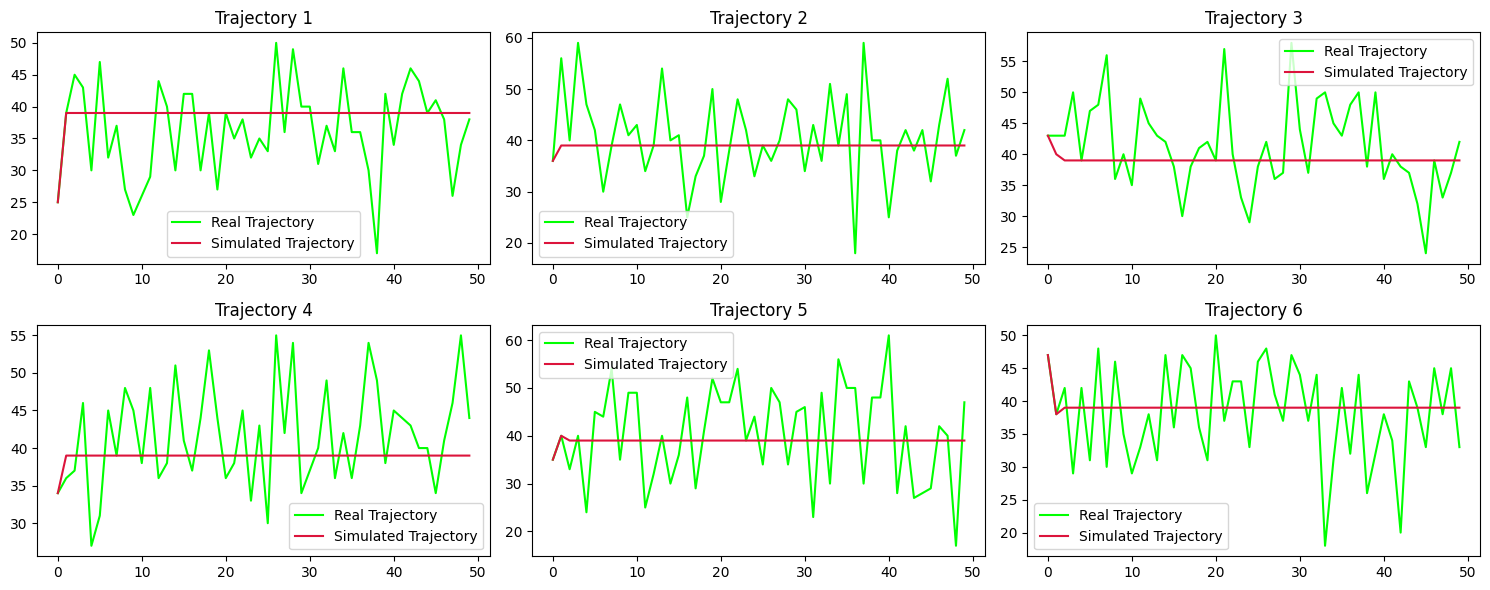

In [115]:
fig, axes = plt.subplots(2, 3, figsize=(15, 6))  # 2 rows, 3 columns, and adjust the size
axes = axes.flatten()
for i in range(6):
    axes[i].plot(test_data[i], label='Real Trajectory', color = 'lime')
    axes[i].plot(trajectories_2[i], label='Simulated Trajectory', color = 'crimson')
    axes[i].legend()
    axes[i].set_title(f'Trajectory {i+1}')
plt.tight_layout()
plt.show()

Autocorrelation

$ACF(k) = Corr(x_t, x_{t-k})$

In [163]:
# Function to calculate ACF for each trajectory
def calculate_acf(trajectories, nlags=10):
    acfs = []
    for traj in trajectories:
        acf_values = acf(traj, fft=False, nlags=nlags)
        acfs.append(acf_values)
    return np.array(acfs)

# Function to calculate PACF for each trajectory
def calculate_pacf(trajectories, nlags=10):
    pacfs = []
    for traj in trajectories:
        pacf_values = pacf(traj, nlags=nlags)
        pacfs.append(pacf_values)
    return np.array(pacfs)

# ACFs for real and simulated trajectories
real_acfs = calculate_acf([test_data[i][1:] for i in range(len(test_data))])
simulated_acfs = calculate_acf(pure_fake)
# Average the ACFs across all trajectories
avg_real_acf = np.mean(real_acfs, axis=0)
avg_simulated_acf = np.mean(simulated_acfs, axis=0)

# Calculate PACFs for real and simulated trajectories
real_pacfs = calculate_pacf([test_data[i][1:] for i in range(len(test_data))])
simulated_pacfs = calculate_pacf(pure_fake)
# Average the PACFs across all trajectories
avg_real_pacf = np.mean(real_pacfs, axis=0)
avg_simulated_pacf = np.mean(simulated_pacfs, axis=0)

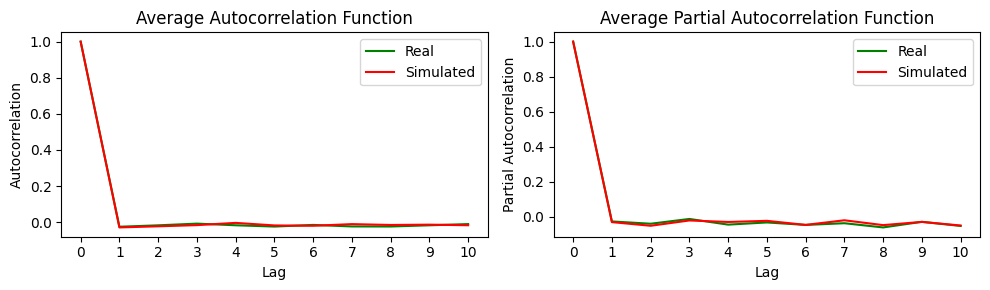

In [164]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# Plot the averaged ACFs
axs[0].plot(avg_real_acf, label='Real', color='green')
axs[0].plot(avg_simulated_acf, label='Simulated', color='red')
axs[0].set_title('Average Autocorrelation Function')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('Autocorrelation')
axs[0].set_xticks(np.arange(0, 11, 1))
axs[0].legend()

# Plot the averaged PACFs
axs[1].plot(avg_real_pacf, label='Real', color='green')
axs[1].plot(avg_simulated_pacf, label='Simulated', color='red')
axs[1].set_title('Average Partial Autocorrelation Function')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('Partial Autocorrelation')
axs[1].set_xticks(np.arange(0, 11, 1))
axs[1].legend()

plt.tight_layout()
plt.show()


### PPO Implementation

$J(s,a,\theta_k,\theta) = min(\frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}*A(s,a), clip(\frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}, 1 - \epsilon, 1 + \epsilon)*A(s,a))$

LSTM Framework

In [177]:
class LSTMGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMGenerator, self).__init__()
        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # Fully Connected Layer for action logits
        self.fc_action = nn.Linear(hidden_dim, output_dim)
        # Fully Connected Layer for value output
        self.fc_value = nn.Linear(hidden_dim, 1)
    
    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        lstm_out, hidden = self.lstm(embedded, hidden)
        # Action logits output
        action_logits = self.fc_action(lstm_out)
        # Value output
        value = self.fc_value(lstm_out)
        return action_logits, value, hidden


In [179]:
dummy_model = LSTMGenerator(vocab_size=num_bins, embedding_dim=32, hidden_dim=64, output_dim=num_bins)

[[33 45 41 40 45 34 34 41 37 48 49 40 44 34 38 43 47 47 32 39 33 42 41 30
  39 39 38 41 46 39 46 34 39 43 40 36 42 42 35 40 44 39 40 27 40 38 46 33
  33 32]
 [36 40 33 34 39 46 40 40 43 41 38 39 40 45 35 36 38 39 40 38 30 36 38 41
  30 34 36 45 46 43 42 48 41 40 33 38 35 39 38 39 39 46 36 43 33 39 49 47
  35 38]
 [24 39 39 43 38 36 37 36 48 42 40 46 33 37 32 37 41 46 37 49 25 37 39 45
  44 36 44 30 38 41 28 30 35 38 36 30 41 48 35 41 49 56 37 33 47 37 49 31
  55 40]]


In [198]:
h_n = torch.zeros(1, 1, 64)
c_n = torch.zeros(1, 1, 64)

dummy_inputs = torch.tensor([train_data[0]])

print(dummy_inputs)
print(dummy_inputs.shape)
print('')

dummy_inputs = torch.tensor(train_data[0]).unsqueeze(0)

print(dummy_inputs)
print(dummy_inputs.shape)
print('')


logits, value, (h_n, c_n) = dummy_model(dummy_inputs, (h_n, c_n))

print(logits.shape)
print(value.shape)



tensor([[33, 45, 41, 40, 45, 34, 34, 41, 37, 48, 49, 40, 44, 34, 38, 43, 47, 47,
         32, 39, 33, 42, 41, 30, 39, 39, 38, 41, 46, 39, 46, 34, 39, 43, 40, 36,
         42, 42, 35, 40, 44, 39, 40, 27, 40, 38, 46, 33, 33, 32]])
torch.Size([1, 50])

tensor([[33, 45, 41, 40, 45, 34, 34, 41, 37, 48, 49, 40, 44, 34, 38, 43, 47, 47,
         32, 39, 33, 42, 41, 30, 39, 39, 38, 41, 46, 39, 46, 34, 39, 43, 40, 36,
         42, 42, 35, 40, 44, 39, 40, 27, 40, 38, 46, 33, 33, 32]])
torch.Size([1, 50])

torch.Size([1, 50, 80])
torch.Size([1, 50, 1])
